# Colored Noise

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

import arviz as az
import h5py
from scipy.interpolate import interp1d
from scipy.signal import welch, decimate
from scipy.signal.windows import tukey
import seaborn as sns
import stan_jupyter as stan

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


## Some random notes from Lecture

Correlated Noise

In [2]:
Sigma = array([[2.0, sqrt(2)*sqrt(3)*0.9], [sqrt(2)*sqrt(3)*0.9, 3]])

xs = np.random.multivariate_normal(zeros(2), Sigma, size=1000)

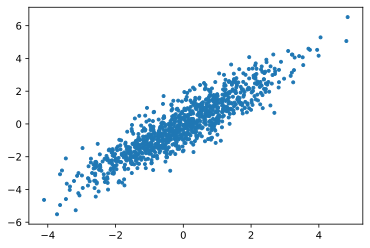

In [5]:
plot(xs[:,0], xs[:,1], '.')

Here we made a Gaussian process with kernel 
$$
k\left( x_i, x_j \right) = \sigma^2 \exp\left( -\frac{1}{2} \left(\frac{x_i - x_j}{\lambda} \right)^2 \right).
$$
For obvious reasons, this is called the "squared exponential kernel."  A good place to learn a lot about Gaussian processes, kernel functions, etc, etc, is {cite}`RasmussenWilliams`, which can be found online [here](http://www.gaussianprocess.org/gpml/chapters/).

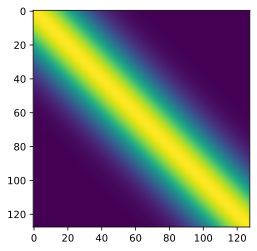

In [21]:
xs = linspace(-1, 1, 128)

sigma2 = 10.0
lambda2 = 0.1
def k(xi, xj):
    return sigma2*np.exp(-0.5*np.square(xi-xj)/lambda2)

Sigma = zeros((128,128))
for i in range(128):
    for j in range(128):
        Sigma[i,j] = k(xs[i], xs[j])

imshow(Sigma)

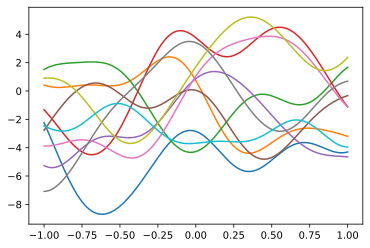

In [22]:
for i in range(10):
    plot(xs, np.random.multivariate_normal(zeros_like(xs), Sigma))

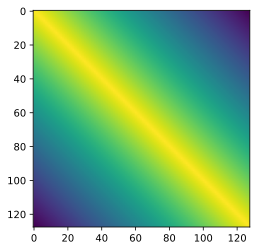

In [25]:
xs = linspace(-1, 1, 128)

sigma2 = 10.0
tau = 10.0
def k(xi, xj):
    return sigma2*np.exp(-np.abs(xi-xj)/tau)

Sigma = zeros((128,128))
for i in range(128):
    for j in range(128):
        Sigma[i,j] = k(xs[i], xs[j])

imshow(Sigma)

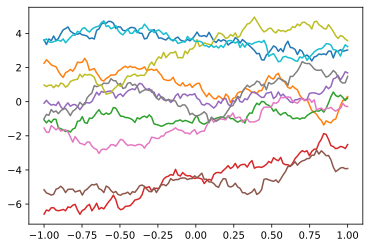

In [26]:
for i in range(10):
    plot(xs, np.random.multivariate_normal(zeros_like(xs), Sigma))

## An Example from LIGO

I downloaded the Hanford LIGO data for GW150914 from [GWOSC](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3).  There are a number of different data products there, but I grabbed the 4 kHz sample rate, 32 second long segment surrounding this event.  I also grabbed the "parameter estimation" posterior samples from the same place.

In [2]:
with h5py.File('data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r') as f:
    strain = array(f['strain/Strain'])
    strain_start = array(f['meta/GPSstart'])[()]
    dt = 1.0 / 4096.0
    strain_times = linspace(0, (len(strain)-1)*dt, len(strain))

In [3]:
with h5py.File('data/GW150914_GWTC-1.hdf5', 'r') as f:
    postsamples = array(f['Overall_posterior'])
t_approx = 1126259462.422

Text(0, 0.5, '$h(t)$')

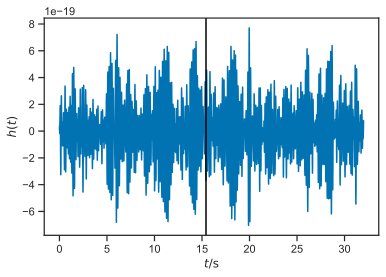

In [4]:
plot(strain_times, strain)
axvline(t_approx - strain_start, color='k')
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h(t)$')

We know the 150914 signal ends at low frequency (< 500 Hz), so we will decimate this data to 1024 sample rate (i.e. by a factor of 4):

In [5]:
lowpass_strain = decimate(strain, 4)
lowpass_strain_times = strain_times[::4]
lowpass_dt = dt*4

In [6]:
T = 0.5
seglen = int(round(T/lowpass_dt))
fs, psd = welch(lowpass_strain, fs=1/lowpass_dt, nperseg=seglen)

Text(0, 0.5, '$P(f) / \\mathrm{strain}^2 \\, \\mathrm{Hz}^{-1}$')

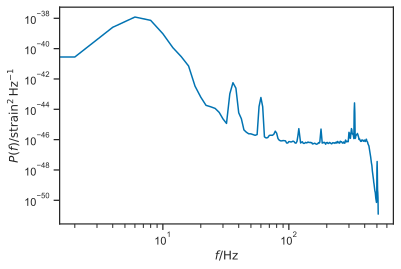

In [7]:
loglog(fs, psd)
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{strain}^2 \, \mathrm{Hz}^{-1}$')

Let's whiten the data: the PSD measures the density of the variance in frequency space, so the s.d. in a frequency bin is $\sqrt{P(f)*\delta f}$:

In [8]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [9]:
white_strain = whiten(lowpass_strain, interp1d(fs, psd), lowpass_dt)

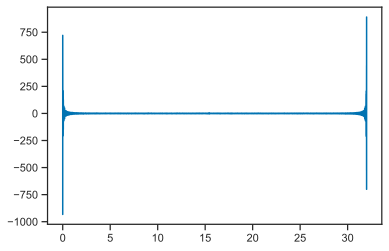

In [10]:
plot(lowpass_strain_times, white_strain)

Funky things happen at the end of the segment.  Why is that?  (Periodicity.)  It's better to whiten a *windowed* version of the data that enforces periodicity.  Here we use a Tukey window (which tapers off to zero on either end over one-second intervals):

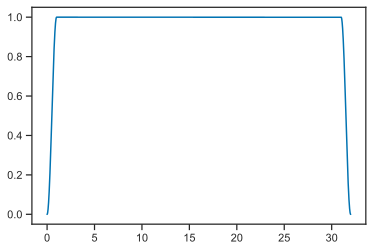

In [11]:
strain_window = tukey(len(lowpass_strain), alpha=2/32)
plot(lowpass_strain_times, strain_window)

In [12]:
white_strain = whiten(lowpass_strain*strain_window, interp1d(fs, psd), lowpass_dt)

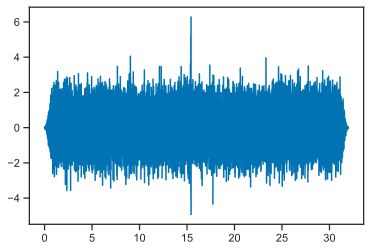

In [13]:
plot(lowpass_strain_times, white_strain)

And here's our merger:

Text(0, 0.5, '$h(t)$ (whitened)')

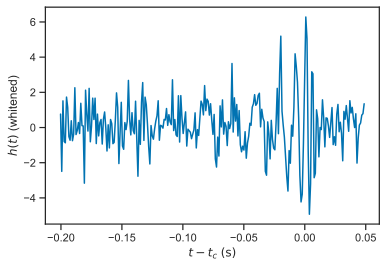

In [14]:
imerg = argmin(abs(lowpass_strain_times - (t_approx - strain_start)))
rng = range(int(round(imerg-0.2/lowpass_dt)),int(round(imerg+0.05/lowpass_dt)))
plot(lowpass_strain_times[rng]-(t_approx-strain_start), white_strain[rng])
xlabel(r'$t - t_c$ $(\mathrm{s})$')
ylabel(r'$h(t)$ (whitened)')

A good place to go for discussions like what we are about to have is the ["GW150914 basic physics" paper](https://arxiv.org/abs/1608.01940) {cite}`GW150914Basic`; for "real" post Newtonian expansions, see {cite}`Blanchet2014`.  The basic physics paper gives the evolution of the *inspiral* phase with time:
$$
f_\mathrm{GW} = \frac{5^{3/8}}{\left( 8 \pi \right)} \left( \frac{G M_c}{c^3} \right)^{-5/8} \left( t - t_c \right)^{-3/8}
$$

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_60841/3102124229.py:2: RuntimeWarning: invalid value encountered in power
  fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)


Text(0, 0.5, '$f_{\\mathrm{GW}} / \\mathrm{Hz}$')

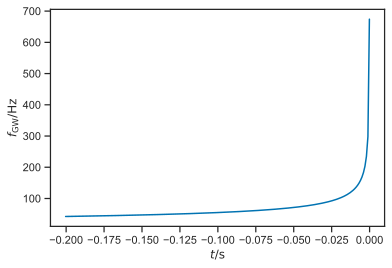

In [15]:
ts = lowpass_strain_times[rng]-(t_approx-strain_start)
fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)
plot(ts, fs)
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$f_{\mathrm{GW}} / \mathrm{Hz}$')

Because the inspiral frequency reaches $\infty$ in finite time, we will have to do something.  Here's something:
 * To truncate the frequency at some $f_\mathrm{max}$ (a parameter).
 * To have an exponentially-damped amplitude decay once the frequency reaches $f_\mathrm{max}$.
 * To use a power-law amplitude with unknown index.

So
$$
h(t) = A_{100} \left( \frac{f(t)}{100 \, \mathrm{Hz}} \right)^\alpha \cos \left( \phi_0 + \Phi(t) \right) \frac{1}{1 + \exp\left( \frac{t - t\left(f_\mathrm{max}\right)}{\tau} \right)}
$$
with
$$
f(t) = \begin{cases}
\left( \frac{\left( 8 \pi \right)^{8/3}}{5} \left( \frac{G \mathcal{M}}{c^3} \right)^{5/3} \left( t_c - t \right) \right)^{-3/8} & f(t) < f_\mathrm{max} \\
f_\mathrm{max} & \mathrm{otherwise}
\end{cases}
$$

In [16]:
def low_pass_filter_amplitude(fs, frolloff, fwidth):
    return 1.0/(1.0 + exp((fs - frolloff)/fwidth))
def basic_waveform(ts, A100, dlnAdlnf, Mc, tc, phic, max_freq, tau):
    fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)

    tmax = tc - max_freq**(-8.0/3.0)/(1100.0*(4.9e-6*Mc)**(5.0/3.0))
    
    Phiinsp = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - ts)**(5.0/8.0)
    Phiconst = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - tmax)**(5.0/8.0) + 2.0*pi*max_freq*(tmax-ts)
    
    Phi = where(ts < tmax, Phiinsp, Phiconst)
        
    fs[(fs >= max_freq) | (ts >= tc)] = max_freq
    
    amps = A100*(fs/100)**dlnAdlnf
    
    return (1.0-low_pass_filter_amplitude(fs, 30.0, 2.0))*amps*cos(phic - Phi)*low_pass_filter_amplitude(ts, tmax, tau)

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_60841/4150586030.py:4: RuntimeWarning: invalid value encountered in power
  fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)
/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_60841/4150586030.py:8: RuntimeWarning: invalid value encountered in power
  Phiinsp = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - ts)**(5.0/8.0)


Text(0, 0.5, 'Whitened Strain')

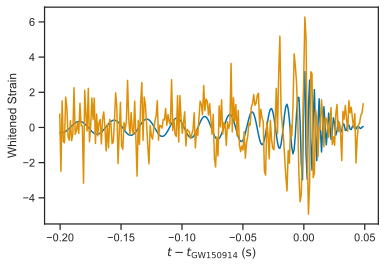

In [17]:
plot(ts, basic_waveform(ts, 2.0, 1.5, 30.0, 0.0, 0.0, 250.0, 0.01))
plot(ts, white_strain[rng])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

In [30]:
data = {
    'nt': len(ts),
    'ts': ts,
    'h_obs': white_strain[rng]
}
with open('stan/phenom_model.stan', 'r') as f:
    code = f.read()
model = stan.build(program_code=code, data=data)

Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.6s
Building: 6.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunu

Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/Users/wfarr/miniconda3/envs/Astrostatistics688

Building: 7.3s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.4s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/Users/wfarr/miniconda3/envs/Astrostatistics688/

Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/wfarr/min

Building: 10.6s
Building: 10.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/wfarr/min

Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.6s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:121:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /U

Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.2s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:153:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                          

Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.1s
Building: 20.2s
Building

In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:28:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/operands_and_partials.hpp:29:1: warning: 'ops_partials_edge' defined as a class template here but previously declared as a struct template; this is valid, but may result in linker errors under the Microsoft C++ ABI [-Wmis

Building: 20.4s
Building: 20.5s
Building: 20.6s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  si

Building: 20.8s
Building: 20.9s
Building: 21.0s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  cons

Building: 21.2s
Building: 21.3s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:307:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/wfarr/miniconda3/

Building: 22.3s
Building: 22.4s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:8:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/io/deserializer.hpp:337:28: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'Eigen::Index' (aka 'long') [-Wsign-compare]
      for (size_t i = 0; i < m; ++i) {
                         ~ ^ ~


Building: 22.5s
Building: 22.6s
Building: 22.8s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:270:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int>>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:538:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::alloc

Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/Users/wfarr/mini

Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/wfarr/miniconda3/envs/Astrost

Building: 25.3s
Building: 25.4s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/wfarr/miniconda3/envs/Astrost

Building: 25.5s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.4s
Building: 26.5s
Building: 26.6s
Building: 26.8s
Building: 26.9s
Building: 27.0s
Building: 27.1s
Building: 27.3s
Building: 27.4s
Building: 27.5s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/wfarr/miniconda3/en

Building: 27.6s
Building: 27.7s
Building: 27.9s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:94:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/wfarr/miniconda3/env

Building: 28.0s
Building: 28.1s
Building: 28.2s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:34:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/columns_dot_self.hpp:7:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/dot_self.hpp:28:24: warning: comparison of integers of different signs: 

Building: 28.3s
Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/wfarr/miniconda3/en

Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.6s
Building: 29.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.cpp:2:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^

Building: 29.8s
Building: 29.9s
Building: 30.0s
Building: 30.1s
Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.5s
Building: 31.6s
Building: 31.7s
Building: 31.8s
Building: 31.9s
Building: 32.0s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.6s
Building: 32.7s
Building: 32.8s
Building: 32.9s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.5s
Building: 33.6s
Building: 33.7s
Building: 33.8s
Building: 33.9s
Building: 34.0s
Building: 34.2s
Building: 34.3s
Building: 34.4s
Building: 34.5s
Building: 34.6s
Building: 34.7s
Building: 34.8s
Building: 34.9s
Building: 35.1s
Building: 35.2s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.7s
Building: 35.8s
Building: 35.9s
Building: 36.1s
Building: 36.2s
Building: 36.3s
Building: 36.4s
Building: 36.5s
Building: 36.6s
Building: 36.7s
Building

59 warnings generated.


Building: 42.6s
Building: 42.8s
Building: 42.9s
Building: 43.0s
Building: 43.1s
Building: 43.2s
Building: 43.3s


ld: warning: -pie being ignored. It is only used when linking a main executable


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/wfarr/Library/Caches/httpstan/4.6.0/models/qsspgd2o/model_qsspgd2o.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/wfarr/Library/Caches/httpsta

In [31]:
fit = az.from_pystan(model.sample(num_chains=4))

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

array([[<AxesSubplot:title={'center':'A100'}>,
        <AxesSubplot:title={'center':'A100'}>],
       [<AxesSubplot:title={'center':'dlnAdlnf'}>,
        <AxesSubplot:title={'center':'dlnAdlnf'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'tc'}>,
        <AxesSubplot:title={'center':'tc'}>],
       [<AxesSubplot:title={'center':'Mc'}>,
        <AxesSubplot:title={'center':'Mc'}>],
       [<AxesSubplot:title={'center':'max_freq'}>,
        <AxesSubplot:title={'center':'max_freq'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

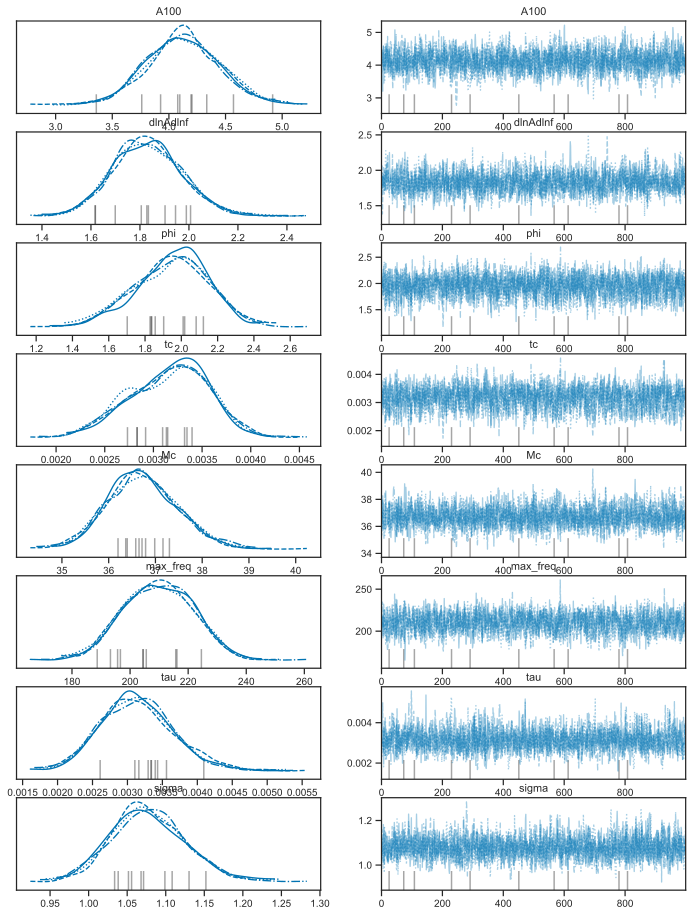

In [32]:
az.plot_trace(fit, var_names=['A100', 'dlnAdlnf', 'phi', 'tc', 'Mc', 'max_freq', 'tau', 'sigma'])

Text(0, 0.5, 'Whitened Strain')

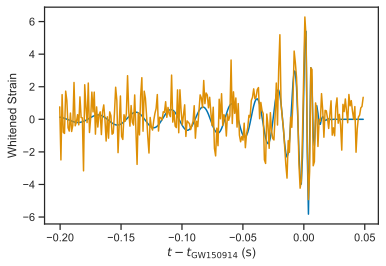

In [33]:
plot(ts, fit.posterior.h_model.mean(axis=(0,1)))
plot(ts, white_strain[rng])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

Note: the "real" value of $M_c$ is $\sim 30 \, M_\odot$.

<AxesSubplot:title={'center':'Mc'}>

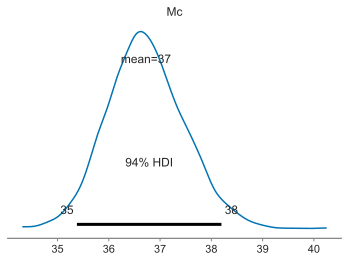

In [34]:
az.plot_posterior(fit, var_names='Mc')